# 3.1. Linear Regression

### Vectorization for Speed

In [ ]:
!pip install d2l

In [2]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [3]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [4]:
class Timer: #@save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()
    
    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [5]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.10587 sec'

In [6]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00050 sec'

### The Normal Distribution and Squared Loss

In [7]:
# normal distribution function

def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

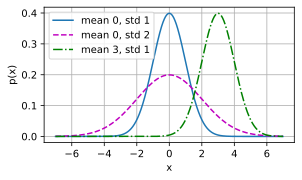

In [8]:
# Use numpy again for visiualization

x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs

params = [(0,1), (0,2), (3,1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel = 'x',
         ylabel = 'p(x)', figsize = (4.5, 2.5),
         legend = [f'mean {mu}, std {sigma}' for mu, sigma in params])

### Summary

- Key ingredients in a machine learning model are training data, a loss function, an optimization algorithm, and quite obviously, the model itself.

- Vectorizing makes everything better (mostly math) and faster (mostly code).

- Minimizing an objective function and performing maximum likelihood estimation can mean the same thing.

- Linear regression models are neural networks, too.

# 3.2. Linear Regression Implementation from Scratch

In [9]:
# import module
%matplotlib inline
import random
import torch
from d2l import torch as d2l

###  Generating the Dataset

In [11]:
def synthetic_data(w, b, num_examples): #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))
    
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [12]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.5102, -1.3062]) 
label: tensor([7.6154])


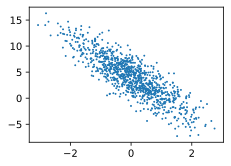

In [13]:
d2l.set_figsize()

# The semicolon is for displaying the plot only

d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### Reading the Dataset

In [14]:
# The function takes a batch size, a matrix of features, and a vector of labels, yielding minibatches of the size batch_size.

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))

    # The examples are read at random, in no particular order
    
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [15]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3883, -0.7845],
        [ 1.1389,  1.5309],
        [ 0.1569, -0.7245],
        [ 1.9381,  0.2925],
        [-0.4234,  0.5300],
        [ 0.9701, -2.0354],
        [ 1.1716, -1.0699],
        [-0.3866,  0.4530],
        [-2.4786,  1.2453],
        [-0.1933,  1.7910]]) 
 tensor([[ 7.6548],
        [ 1.2755],
        [ 6.9792],
        [ 7.0909],
        [ 1.5487],
        [13.0656],
        [10.2046],
        [ 1.8841],
        [-4.9927],
        [-2.2905]])


### Initializing Model Parameters

In [16]:
# we initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.01, and setting the bias to 0.

w =  torch.normal(0, 0.01, size = (2,1), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

### Defining the Model

In [17]:
def linreg(X, w, b): #@save
    """The linear regression model."""
    return torch.matmul(X, w) + b

### Defining the Loss Function

In [18]:
# use the squared loss function
# we need to transform the true value y into the predicted value’s shape y_hat.

def squared_loss(y_hat, y): #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### Defining the Optimization Algorithm

In [19]:
# we normalize our step size by the batch size (batch_size), 
# so that the magnitude of a typical step size does not depend heavily on our choice of the batch size.

def sgd(params, lr, batch_size): #@save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad(): # with as 구문을 빠져나가게 되면 자동으로 close() 함수를 호출하여 파일을 닫음
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### Training

In [20]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`

        # Compute gradient on `l` with respect to [`w`, `b`]

        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
        
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.046204
epoch 2, loss 0.000175
epoch 3, loss 0.000046


In [21]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([0.0002, 0.0003], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0006], grad_fn=<RsubBackward1>)


### Summary

- We saw how a deep network can be implemented and optimized from scratch, using just tensors and auto differentiation, without any need for defining layers or fancy optimizers.

- This section only scratches the surface of what is possible. In the following sections, we will describe additional models based on the concepts that we have just introduced and learn how to implement them more concisely.

# 3.3. Concise Implementation of Linear Regression

### Generating the Dataset

In [22]:
# import module

import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [23]:
# generate the same dataset as in Section 3.2

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### Reading the Dataset

In [24]:
# call upon the existing API in a framework to read data.

def load_array(data_arrays, batch_size, is_train = True): #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [25]:
next(iter(data_iter))

[tensor([[ 1.6704, -1.7717],
         [-0.1945, -0.8624],
         [ 1.0191,  0.8787],
         [ 0.5145, -0.1622],
         [-0.1779,  1.5337],
         [ 1.2000,  0.2536],
         [-0.3299, -0.6591],
         [ 0.2238,  0.4701],
         [ 0.8786, -0.7199],
         [-0.5355,  0.4286]]), tensor([[13.5535],
         [ 6.7526],
         [ 3.2437],
         [ 5.7858],
         [-1.3739],
         [ 5.7282],
         [ 5.7781],
         [ 3.0459],
         [ 8.4302],
         [ 1.6800]])]

### Defining the Model

In [26]:
# `nn` is an abbreviation for neural networks

from torch import nn

net = nn.Sequential(nn.Linear(2,1))

# The first one specifies the input feature dimension, which is 2, 
# and the second one is the output feature dimension, which is a single scalar and therefore 1.

### Initializing Model Parameters

In [27]:
# As we have specified the input and output dimensions when constructing nn.Linear, 
# now we can access the parameters directly to specify their initial values. 
# We first locate the layer by net[0], which is the first layer in the network, 
# and then use the weight.data and bias.data methods to access the parameters. 
# Next we use the replace methods normal_ and fill_ to overwrite parameter values.

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### Defining the Loss Function

In [28]:
# The MSELoss class computes the mean squared error

loss = nn.MSELoss()

### Defining the Optimization Algorithm

In [29]:
# optim module

trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### Training

In [30]:
# Generate predictions by calling net(X) and calculate the loss l (the forward propagation).
# Calculate gradients by running the backpropagation.
# Update the model parameters by invoking our optimizer.

num_epochs = 3

for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad() ###
        l.backward() ###
        trainer.step() ###
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000310
epoch 2, loss 0.000103
epoch 3, loss 0.000103


In [33]:
# compare the model parameters learned by training on finite data and the actual parameters that generated our dataset.
# our estimated parameters are close to their ground-truth counterparts

w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))

b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([ 0.0002, -0.0003])
error in estimating b: tensor([0.0001])


### Summary

- Using PyTorch’s high-level APIs, we can implement models much more concisely.

- In PyTorch, the data module provides tools for data processing, the nn module defines a large number of neural network layers and common loss functions.

- We can initialize the parameters by replacing their values with methods ending with _.